# On the effect of rotation-based self-supervised learning

[Marcos Escudero-Viñolo](http://www-vpu.eps.uam.es/webvpu/gti/user/18/), [Video Processing and Understanding Lab.](http://www-vpu.eps.uam.es/webvpu/es/)

Some parts of this lab have been adapted from the work of [Diego Ortego](https://sites.google.com/view/diegoortego/), [Insight Centre for Data Analytics](https://www.insight-centre.org/) [Dublin City University](https://www.dcu.ie/)

---

This lab will illustrate how to specify and train [RotNet](https://arxiv.org/abs/1803.07728), a pretext task for self-supervised learning that rotates the image by 0, 90, 180 or 270 degrees (i.e. 4 classes) and learns to predict one of the four classes (rotations) for each image.

The training of this task assumes that learning to predict the rotation of an image involves that the network has to locate the object in the image and partially understand its shape and components.

Then we will evaluate the hypothetical advantages of using a-so trained model as a preliminary step in a semi-supervised learning process.

To this aim, we will:
- i) Train a CNN (RotNet) for the self-supervised pretext task (predict rotations) using an unlabeled dataset.
- ii) Transfer this self-supervised trained model to an image classification task using a small labeled dataset.
- iii) Train from scratch a supervised CNN with the same data and CNN architecture used in ii).
- iv) Compare ii) and iii), if the self-supervised is useful, ii) must be better than iii).

## Instructions

Anywhere you see a **???** in the code below, fill in with the correct code (see example below)

In [1]:
import sys
# to fill: print system version:
# ???
# Solution:
print(sys.version)

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


# Preliminaries

## Import packages
Find the PyTorch docs at https://pytorch.org/docs/stable/index.html

Tutorials: https://pytorch.org/tutorials/

In [2]:
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_file_from_google_drive
print('PyTorch version:', torch.__version__)

# additional packages
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import argparse
import os
import time
from os.path import join
import csv
from sklearn import manifold
# install wget for data sharing
import wget
print('Done')

PyTorch version: 2.0.1
Done


## Hyperparameters + Enable GPU acceleration

### Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and check that *GPU* is selected under hardware accelerator.


In [3]:
# make sure to enable GPU acceleration!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Define method's hyper-parameters
You may return here to change them in order to accelerate the training or evaluate their effect in the process.


In [4]:
class configuration:
  def __init__(self):
    self.experiment_name = "PR.3."

    self.num_classes = 4 # for pretext class

    self.lr = 0.1        #learning rate
    self.batch_size = 80 #Training batch size
    self.test_batch_size = 100 #Test batch size

    # [reduced to accelerate training at the expense of yielding worse features and acc. Use a larger number >=45 when you are sure on the operation of your code]
    self.epoch_pretext = 45 #45
    self.M_pretext = [37, 43] #[37, 43] # or adapt consequently according to self.epoch_pretext

    self.epoch_class   = 45 #45
    self.M_class       = [37, 43] #[37, 43] # or adapt consequently according to self.epoch_class

    self.train_root = "./miniImagenet84"
    self.MaximumNumberOfImagesPerSet = 50*480 # [nclases x 480 instances/samples per class]
                                              # [reduce nclases to accelerate training at the expense of yielding worse features and acc.]
                                              # [increase nclasses to increase the diverstiy of the training and validation sets]
                                              # [always leave 480 (the number of instances/samples per class) unaltered]
                                              # [set to 50*480=24000 to use the whole dataset]

    self.seed = 271828  # for reproducibility

## Create arguments object
args = configuration()

We set the random seed so (we believe) all of our experiments can be reproduced

In [5]:
# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

# Prepare training and validation data


## Download dataset
We will use wget to download data.

In [6]:
"""
url = 'http://www-vpu.eps.uam.es/misc/DL4IP/miniImagenet84.tar'
filename = wget.download(url, out='./miniImageNet.tar')
!tar xf miniImageNet.tar
!rm miniImageNet.tar
"""

"\nurl = 'http://www-vpu.eps.uam.es/misc/DL4IP/miniImagenet84.tar'\nfilename = wget.download(url, out='./miniImageNet.tar')\n!tar xf miniImageNet.tar\n!rm miniImageNet.tar\n"

## Dataset loading
We will use a subset of the ImageNet dataset with 60000 images. To accelerate training processes, we will use a maximum of ***MaximumNumberOfImagesPerSet*** (see Hyper-parameters) images per set, and images are of reduced resolution (84x84).

Half of these images will be used for the training and validation of the pretext task. The other half will be used for the training and validation of the classification task. This code preloads the images (they are loaded just once).


In [7]:
def load_dataset(args):
    np.random.seed(42)
    # read and store training images for pretext task
    csv_file = "train_pretext.csv"
    in_csv_path = join(args.train_root, csv_file)
    in_images_path = join(args.train_root, "images")
    train_pil_images_pretext = []
    train_labels_pretext_list = []
    print("Loading training Images for pretext task in memory...")
    with open(in_csv_path) as csvfile:
          csvreader = csv.reader(csvfile, delimiter=',')
          next(csvreader, None)
          for i,row in enumerate(csvreader):
            if i < args.MaximumNumberOfImagesPerSet:
              train_pil_images_pretext.append(np.asarray(Image.open(join(in_images_path,row[0]))))
              train_labels_pretext_list.append(0.) # labels are not used for the pretext task

    train_data_pretext = np.asarray(train_pil_images_pretext)
    train_labels_pretext = torch.FloatTensor(train_labels_pretext_list)

    # read and store validation images for pretext task
    csv_file = "val_pretext.csv"
    in_csv_path = join(args.train_root, csv_file)
    in_images_path = join(args.train_root, "images")
    val_pil_images_pretext = []
    val_labels_pretext_list = []
    print("Loading validation Images for pretext task in memory...")
    with open(in_csv_path) as csvfile:
          csvreader = csv.reader(csvfile, delimiter=',')
          next(csvreader, None)
          for i,row in enumerate(csvreader):
            if i < round(args.MaximumNumberOfImagesPerSet/4): # validation set is 4 times smalller than train one
              val_pil_images_pretext.append(np.asarray(Image.open(join(in_images_path,row[0]))))
              val_labels_pretext_list.append(0.) # labels are not used for the pretext task

    val_data_pretext   = np.asarray(val_pil_images_pretext)
    val_labels_pretext = np.asarray(val_labels_pretext_list)

    # read and store training images for classification task
    # Labels will be used for this task.
    csv_file = "train_classification.csv"
    in_csv_path = join(args.train_root, csv_file)
    in_images_path = join(args.train_root, "images")
    train_pil_images_class = []
    train_labels_class_list = []
    print("Loading training Images for classification task in memory...")
    with open(in_csv_path) as csvfile:
          csvreader = csv.reader(csvfile, delimiter=',')
          next(csvreader, None)
          for i,row in enumerate(csvreader):
            if i < args.MaximumNumberOfImagesPerSet:
              train_pil_images_class.append(np.asarray(Image.open(join(in_images_path,row[0]))))
              train_labels_class_list.append(float(row[1]))

    train_data_class   = np.asarray(train_pil_images_class)
    # We define a mapping to renumber labels
    mapping = {y: x for x, y in enumerate(np.unique(train_labels_class_list))}
    train_labels_class = [mapping[i] for i in train_labels_class_list]        

    # to fill: read and store validation images for classification task
    # use the same process and validation ratio as the one used for the pretext task, but use labels now as in the previous training set
    # store images in val_data_class and labels in val_labels_class
    csv_file = "val_classification.csv"
    in_csv_path = join(args.train_root, csv_file)
    in_images_path = join(args.train_root, "images")
    val_pil_images_class = []
    val_labels_class_list = []
    print("Loading validation Images for classification task in memory...")
    with open(in_csv_path) as csvfile:
          csvreader = csv.reader(csvfile, delimiter=',')
          next(csvreader, None)
          for i,row in enumerate(csvreader):
            if i < round(args.MaximumNumberOfImagesPerSet/4):
              val_pil_images_class.append(np.asarray(Image.open(join(in_images_path,row[0]))))
              val_labels_class_list.append(float(row[1]))

    val_data_class = np.asarray(val_pil_images_class)
    # We define a mapping to renumber labels
    mapping = {y: x for x, y in enumerate(np.unique(val_labels_class_list))}
    val_labels_class = [mapping[i] for i in val_labels_class_list]

    return train_data_pretext, train_labels_pretext, val_data_pretext, val_labels_pretext, train_data_class, train_labels_class, val_data_class, val_labels_class

Preload the images and store them in verbose variables

In [8]:
# Image loading
train_data_pretext, train_labels_pretext, val_data_pretext, val_labels_pretext, train_data_class, train_labels_class, val_data_class, val_labels_class = load_dataset(args)
print('-------> Data loaded')

Loading training Images for pretext task in memory...


Loading validation Images for pretext task in memory...
Loading training Images for classification task in memory...
Loading validation Images for classification task in memory...
-------> Data loaded


## Define class to encapsulate the dataset
First we define a function to perform the possible rotations of the images for the pretext class.

Then we define a class (**MiniImagenet84**) to accomodate the dataset.

This class is defined such that it can be used for both the pretext and the classification tasks. To this aim the class returns both the four rotated versions of the images and the original image (with the associated labels in both cases).

Rotations are to be performed counterclockwise, but this shouldn't change the learning outcomes.

In [9]:
def rotate_img(img, rot):
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 90:  # 90 degrees rotation
        return img.rotate(90)
    elif rot == 180:  # to fill: 180 degrees rotation
        return img.rotate(180)
    elif rot == 270:  # to fill: 270 degrees rotation / or -90
        return img.rotate(270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

class MiniImagenet84(Dataset):

    def __init__(self, args, data, labels, train=True, transform_pre=None, transform_pre_test=None, transform=None, target_transform=None):

        self.args = args
        self.data, self.labels = data, labels
        self.transform_pre = transform_pre
        self.transform_pre_test = transform_pre_test
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

    ##getitem method is always defined in the dataset class to define the operations
    def __getitem__(self, index):
        ## Get path of image to load and associated label
        img, labels = self.data[index], self.labels[index]

        ## Load image
        img = Image.fromarray(img)

        ## Data transformations (data augmentation)
        if self.transform_pre is not None and self.train == True:
            img = self.transform_pre(img)
        elif self.train == False:
            img = self.transform_pre_test(img)

        ## List of 4 images, each with a different rotation [for the pretext task]
        rotated_imgs = [
            self.transform(img), ## 0 degrees rotation
            self.transform(rotate_img(img,90).copy()), ## 90 degrees rotation
            self.transform(rotate_img(img,180).copy()), ## to fill: 180 degrees rotation
            self.transform(rotate_img(img,270).copy())  ## to fill: 270 degrees rotation
        ]
        ## Create rotation labels, i.e. 4 (0-3)
        rot_labels = torch.LongTensor([0, 1, 2, 3])
        ## Stack the list of rotated images into a tensor
        rot_img = torch.stack(rotated_imgs, dim=0)
        ## Data transformations to tensor and normalization
        img = self.transform(img)

        ## We also return the original image and its label in the 3rd and 4th outputs
        return rot_img, rot_labels, img, labels, index

    def __len__(self):
        return len(self.data)

## Image transformations
Defines the transformations to be performed on dataset images , including normalization and simple data augmentation strategies.

In [10]:
# 1. Simple data augmentation

## Transformations for training data

## to fill:
### 1st: Pad the image with 6 pixels in every direction
### 2nd: Crop the image at a random location to get a 64x64 crop in.
### Check https://pytorch.org/docs/stable/torchvision/transforms.html to find the funcitons
transform_pre = transforms.Compose([
    transforms.Pad(padding=6),
    transforms.RandomCrop(size=64)
])

## Transformations for test data
## to fill: take a 64x64 crop in from the image center.
transform_pre_test = transforms.Compose([
    transforms.CenterCrop(size=64)
])

# 2. Normalization

## Dataset statistics
mean = [0.4728, 0.4487, 0.4031]
std = [0.2744, 0.2663 , 0.2806]
## Transformations for training data
## to fill:
### 1st: Conver to tensor
### 2nd: Normalize
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Transformations for test data
## to fill: apply the same normalization transformation to test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Define the CNN architecture and its training and validation protocols

## CNN architecture
We are using a small and slightly modified ResNet.

The proposed definition allows to define different ResNet versions by using the BasicBlock class.


### Basic Block

The parametrization of the BasicBlock class allows to define structures like the one in the figure.

Try to relate the code with the graphical representation.

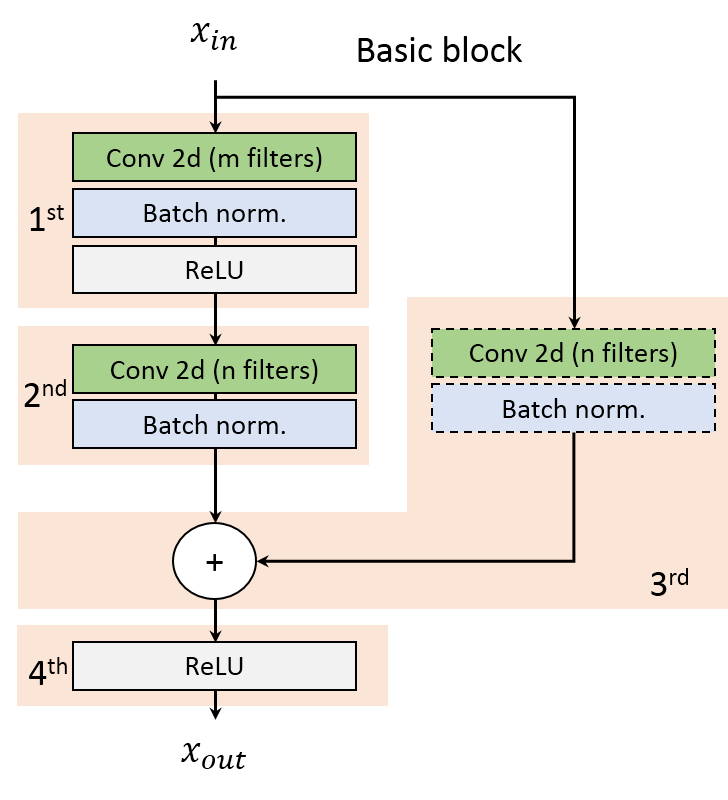


In [11]:
class BasicBlock(nn.Module):
    # to simplify the architecture, reduce the number of parameters and ease training
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    # To fill: complete the forward pass on the Basic Block
    # use the stages in the Figure to complete the code
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # 1st
        out = self.bn2(self.conv2(out)) # 2nd
        out += self.shortcut(x) # 3rd
        out = F.relu(out) # 4th
        return out


### ResNet

Now, several ResNet-like architectures can be obtained by concatenating BasicBlock(s) in a 4-layer fashion.

In the code, each layer j is composed of num_blocks [j-1] BasicBlock(s).

For instance, the example includes a ResNet 34 that can be obtained by the proposed function by using num_blocks = [3,4,6,3].

We will use smaller ResNet in this Lab (ResNet 14) but we will follow the same ratio of filters and donwsampling as in the example. Regarding the output, the example ResNet 34 is configured to predict 1000 classes, we can define the number of output units of the fully connected layer by altering the num_classes parameter.

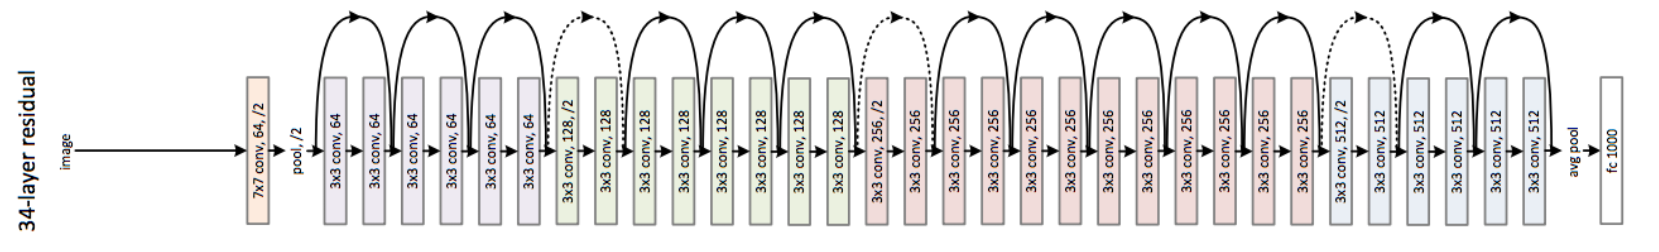



In [12]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64) # this is not in the example but helps.
        # we will avoid the early pooling as images are small.

        # To fill: complete the definition of the ResNet-like architecture
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512*block.expansion, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    # To fill: complete the forward pass on the ResNet-like architecture
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        #### To fill: add forward pass of each of the four layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        #### To fill: add forward pass of the linear layer
        out = self.linear(out)

        return out

## Function to compute accuracy  
We will use this function to compute the accuracy for the classification task.

In [13]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the top-k accuracy between output and target.
    :param output: output vector from the network
    :param target: ground-truth
    :param topk: Top-k results desired, i.e. top1, top5, top10
    :return: vector with accuracy values
    """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))

    return res

## RotNet training epoch
We define two training methods: one for the pretext task and one for the classification task. Both are simple multi-class classification problems, but rely on different information sources.

In [14]:
## For pretext

def train_RotNet_pretext(args, model, device, train_loader, optimizer, epoch):

    train_loss = []
    # switch to train mode
    model.train()
    loss_per_batch = []
    acc_per_batch = []

    counter = 1
    correct = 0

    #### To fill: define a cross-entropy loss criterion. Use a function that directly computes the log_softmax.
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (images, labels, _, _, _) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        size = images.size()
        images = images.view(-1, size[2], size[3], size[4])
        labels = labels.view(-1)

        #### To fill: do forward pass
        outputs = model(images)

        ## Cross-entropy loss with soft labels

        #### To fill: compute cross-entropy loss using the criterion defined above
        loss = criterion(outputs, labels)

        train_loss.append(loss.item())

        acc = accuracy(outputs.data, labels)[0]
        acc_per_batch.append(acc)

        #### To fill: reset gradients
        optimizer.zero_grad()

        #### To fill: perform backpropagation
        loss.backward()

        #### To fill: perfor a gradient descend step
        optimizer.step()

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.0f}%, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)/4), len(train_loader.dataset),
                       100. * counter / len(train_loader), loss.item(),
                       acc_per_batch[-1], optimizer.param_groups[0]['lr']))
        counter = counter + 1

    return sum(train_loss)/len(train_loss), acc_per_batch[-1]

## For classification

def train_RotNet_classification(args, model, device, train_loader, optimizer, epoch):

    train_loss = []
    # switch to train mode
    model.train()
    loss_per_batch = []
    acc_per_batch = []

    counter = 1
    correct = 0

    #### To fill: define a cross-entropy loss criterion. Use a function that directly computes the log_softmax.
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (_, _, images, labels, _) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)

        #### To fill: do forward pass
        outputs = model(images)

        ## Cross-entropy loss with soft labels

        # Compute cross-entropy loss using the criterion defined above
        loss = criterion(outputs, labels.long())

        train_loss.append(loss.item())

        acc = accuracy(outputs.data, labels)[0]
        acc_per_batch.append(acc)

        #### To fill: reset gradients
        optimizer.zero_grad()

        #### To fill: perform backpropagation
        loss.backward()

        #### To fill: perfor a gradient descend step
        optimizer.step()

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.0f}%, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)/4), len(train_loader.dataset),
                       100. * counter / len(train_loader), loss.item(),
                       acc_per_batch[-1], optimizer.param_groups[0]['lr']))
        counter = counter + 1

    return sum(train_loss)/len(train_loss), acc_per_batch[-1]

## RotNet validation epoch
With these functions we define the validation processes. Again we define two functions, one for the pretext and one for the classification task.

In [15]:
def testing_pretext(args, model, device, test_loader):

    #### To fill: define a cross-entropy loss criterion. Use a function that directly computes the log_softmax.
    criterion = nn.CrossEntropyLoss()

    model.eval()
    loss_per_batch = []
    acc_val_per_batch =[]

    with torch.no_grad():
        for batch_idx, (data, target, _, _, _) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            size = data.size()
            data = data.view(-1, size[2], size[3], size[4])
            target = target.view(-1)
            output = model(data)

            ## Compute cross-entropy loss using the criterion defined above
            loss = criterion(output, target.long())

            loss_per_batch.append(loss.item())

            acc = accuracy(output.data, target)[0]
            acc_val_per_batch.append(acc)

    loss_per_epoch = np.average(loss_per_batch)
    acc_val_per_epoch = torch.mean(torch.stack(acc_val_per_batch,0))

    print('\nTest set: Average Loss: {:.6f}, Accuracy: {:.0f}%\n'.format(
                loss_per_epoch, acc_val_per_epoch.item()))

    return ([loss_per_epoch], [acc_val_per_epoch.item()])

def testing_classification(args, model, device, test_loader):

    #### To fill: define a cross-entropy loss criterion. Use a function that directly computes the log_softmax.
    criterion = nn.CrossEntropyLoss()

    model.eval()
    loss_per_batch = []
    acc_val_per_batch =[]

    with torch.no_grad():
        for batch_idx, (_, _, data, target, _) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            size = data.size()
            output = model(data)

            #### Compute cross-entropy loss using the criterion defined above
            loss = criterion(output, target.long())

            loss_per_batch.append(loss.item())

            acc = accuracy(output.data, target)[0]
            acc_val_per_batch.append(acc)

    loss_per_epoch = np.average(loss_per_batch)
    acc_val_per_epoch = torch.mean(torch.stack(acc_val_per_batch,0))

    print('\nTest set: Average Loss: {:.6f}, Accuracy: {:.0f}%\n'.format(
                loss_per_epoch, acc_val_per_epoch.item()))

    return ([loss_per_epoch], [acc_val_per_epoch.item()])

# Pretext task: predicting image rotation
Now we will proceed with the training and validation of the pretext task.

## Create the dataloaders for the training and the validation (test) stages
We first define the dataloaders by arranging datasets.
Observe how the transformation applied to the train and validation data are different.

In [16]:
trainset_pretext     = MiniImagenet84(args, train_data_pretext, train_labels_pretext, train=True, transform_pre=transform_pre, transform=transform_train)
train_loader_pretext = torch.utils.data.DataLoader(trainset_pretext, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)

testset_pretext      = MiniImagenet84(args, val_data_pretext, val_labels_pretext, train=False, transform_pre_test=transform_pre_test, transform=transform_test)
test_loader_pretext  = torch.utils.data.DataLoader(testset_pretext, batch_size=args.test_batch_size, shuffle=False, num_workers=8, pin_memory=True)

### Let's check the datasets for the pretext task
By representing some example image.


First, we should define an unormalized function so we can visualize images in their orginal RGB space.


In [17]:
def unNormalizeImage(image, mean=[0.485, 0.456, 0.406], STD=[0.229, 0.224, 0.225]):
    """
    Unnormalizes a numpy array given mean and STD
    :param image: Image to unormalize
    :param mean: Mean
    :param STD: Standard Deviation
    :return: Unnormalize image
    """
    for i in range(0, image.shape[0]):
        image[i, :, :] = (image[i, :, :] * STD[i]) + mean[i]
    return image


Now we can represent the first image in the test loader as an example

Text(0.5, 1.0, 'Rotation 270')

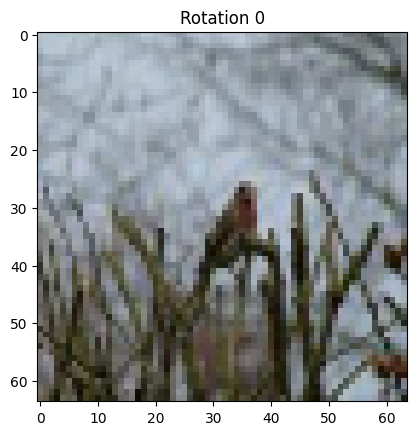

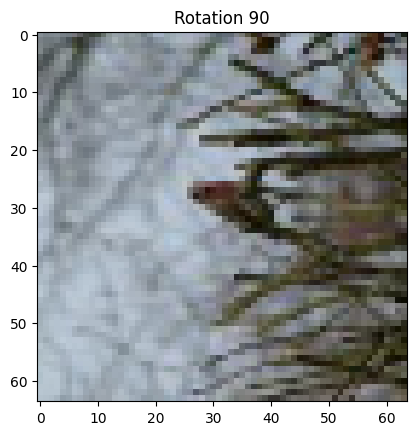

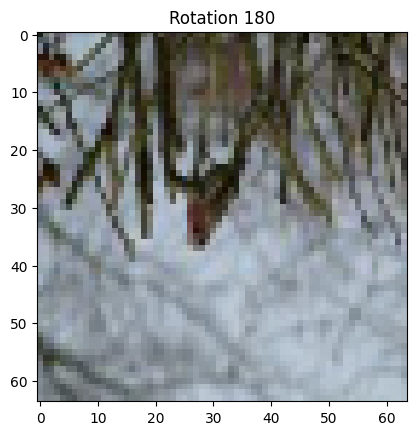

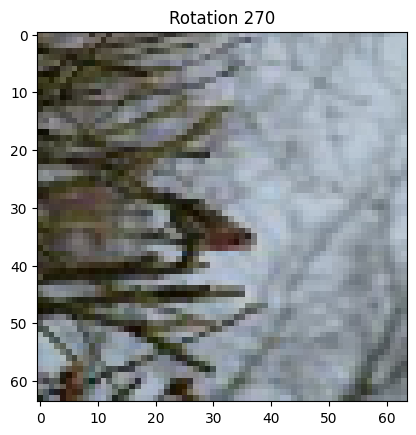

In [18]:
rot_img, rot_labels, img, labels, index = next(iter(test_loader_pretext))
c_rot_img = rot_img[0,:,:,:]

rot_0   = np.transpose(unNormalizeImage(c_rot_img[0,:,:].numpy(), mean=mean, STD=std), [1,2,0])
## To fill: extract the other rotated images simirarly, by propertly indexing c_rot_img
rot_90  = np.transpose(transforms.functional.rotate(c_rot_img[0,:,:], 90).numpy(), [1,2,0])
rot_180 = np.transpose(transforms.functional.rotate(c_rot_img[0,:,:], 180).numpy(), [1,2,0])
rot_270 = np.transpose(transforms.functional.rotate(c_rot_img[0,:,:], 270).numpy(), [1,2,0])

plt.figure()
plt.imshow(rot_0)
plt.title('Rotation 0')
plt.figure()
plt.imshow(rot_90)
plt.title('Rotation 90')
plt.figure()
plt.imshow(rot_180)
plt.title('Rotation 180')
plt.figure()
plt.imshow(rot_270)
plt.title('Rotation 270')

## Define the model architecture
We will use a ResNet like architecture of 1+(14) convolutional layers with 2 BasicBlocks in the first and third layers and 1 BasicBlock in the second and fourth layers.


In [19]:
#### To fill: complete the definition of the ResNet(-like)-14 architecture:
## args.num_classes = 4 classes are to be predicted.
## We have defined this number in the Hyperparameters, but why?
model_pretext = ResNet(BasicBlock, [3,4,6,3], args.num_classes).to(device) ##ResNet-14

## Define the optimizer and the scheduler

In [20]:
## Change associated hyperparamters to accelerate or improve training.
optimizer = optim.SGD(model_pretext.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.M_pretext, gamma=0.1)

## Training loop for pretext task

In [21]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch_pretext + 1):
    st = time.time()

    # To fill: Train for one epoch
    print("Self-supervised Learning (RotNet), epoch " + str(epoch))
    loss_per_epoch, top1_train_ac = train_RotNet_pretext(args, model_pretext, device, train_loader_pretext, optimizer, epoch)

    loss_train_epoch += [loss_per_epoch]

    scheduler.step()

    # To fill: test/validate
    loss_per_epoch_test, acc_val_per_epoch_i = testing_pretext(args, model_pretext, device, test_loader_pretext)

    loss_test_epoch += loss_per_epoch_test
    acc_train_per_epoch += [top1_train_ac.item()]
    acc_test_per_epoch += acc_val_per_epoch_i


    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i[-1]

    else:
        if acc_val_per_epoch_i[-1] > best_acc_val:
            best_acc_val = acc_val_per_epoch_i[-1]

    if epoch==args.epoch_pretext:
        torch.save(model_pretext.state_dict(), "RotNetPretext.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_train.npy', np.asarray(acc_train_per_epoch))
    np.save(res_path + '/' + 'accuracy_per_epoch_val.npy', np.asarray(acc_test_per_epoch))

    cont += 1

Self-supervised Learning (RotNet), epoch 1
Train Epoch: 1 [1200/24000 (5%)]	Loss: 1.683275, Accuracy: 25%, Learning rate: 0.100000
Train Epoch: 1 [2400/24000 (10%)]	Loss: 2.238983, Accuracy: 25%, Learning rate: 0.100000
Train Epoch: 1 [3600/24000 (15%)]	Loss: 1.537160, Accuracy: 26%, Learning rate: 0.100000
Train Epoch: 1 [4800/24000 (20%)]	Loss: 1.531071, Accuracy: 25%, Learning rate: 0.100000
Train Epoch: 1 [6000/24000 (25%)]	Loss: 1.426591, Accuracy: 24%, Learning rate: 0.100000
Train Epoch: 1 [7200/24000 (30%)]	Loss: 1.385853, Accuracy: 27%, Learning rate: 0.100000
Train Epoch: 1 [8400/24000 (35%)]	Loss: 1.418753, Accuracy: 25%, Learning rate: 0.100000
Train Epoch: 1 [9600/24000 (40%)]	Loss: 1.412614, Accuracy: 26%, Learning rate: 0.100000
Train Epoch: 1 [10800/24000 (45%)]	Loss: 1.378848, Accuracy: 28%, Learning rate: 0.100000
Train Epoch: 1 [12000/24000 (50%)]	Loss: 1.393326, Accuracy: 27%, Learning rate: 0.100000
Train Epoch: 1 [13200/24000 (55%)]	Loss: 1.382349, Accuracy: 27%, 

## Accuracy and loss curves for pretext task

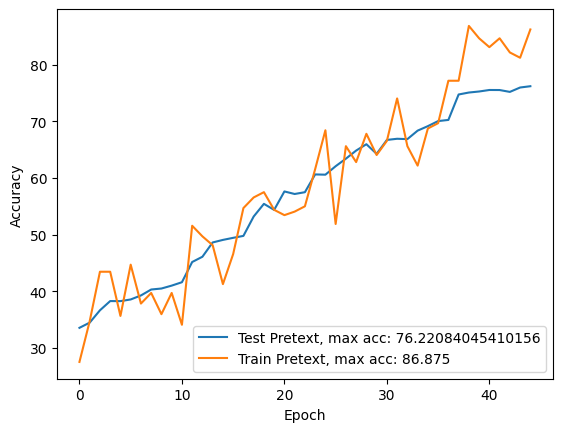

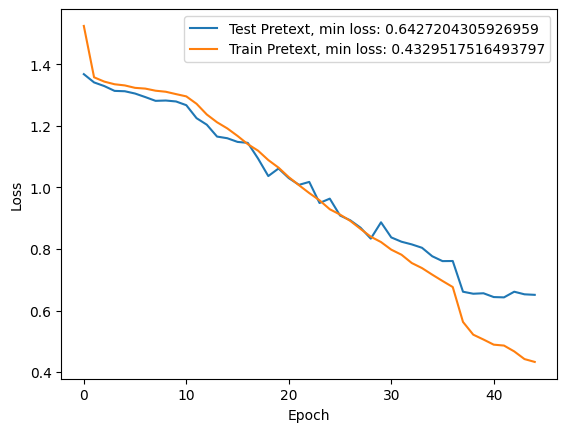

In [22]:
##Accuracy
acc_train_pretext = np.asarray(acc_train_per_epoch)
acc_test_pretext  = np.asarray(acc_test_per_epoch)

#Loss per epoch
loss_test_pretext = np.asarray(loss_test_epoch)
loss_train_pretext = np.asarray(loss_train_epoch)

numEpochs = len(acc_train_pretext)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test_pretext, label='Test Pretext, max acc: ' + str(np.max(acc_test_pretext)))
plt.plot(epochs, acc_train_pretext, label='Train Pretext, max acc: ' + str(np.max(acc_train_pretext)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test_pretext, label='Test Pretext, min loss: ' + str(np.min(loss_test_pretext)))
plt.plot(epochs, loss_train_pretext, label='Train Pretext, min loss: ' + str(np.min(loss_train_pretext)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

# Classification task: transfer learning from pretext task
Now we will proceed with the training and validation of the classification task, starting from the learned self-supervised model.

## Create the dataloaders for the training and the validation (test) stages

In [23]:
# To fill: follow the same organization as for the pretext task, but use now the train_data_class and train_labels_class sets.
trainset_class     = MiniImagenet84(args, train_data_class, train_labels_class, train=True, transform_pre=transform_pre, transform=transform_train)
train_loader_class =  torch.utils.data.DataLoader(trainset_class, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)

# To fill: follow the same organization as for the pretext task, but use now the val_data_class and val_labels_class sets.
testset_class     = MiniImagenet84(args, val_data_class, val_labels_class, train=False, transform_pre_test=transform_pre_test ,transform=transform_test)
test_loader_class = torch.utils.data.DataLoader(testset_class, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)

## Define the model architecture
Change the last layer of the self-supervised learned model and intialize the new model by copying all the weights but those in the last layer

In [24]:
# i) Define a randomly initialized architecture with appropiate number of classes.
num_classes_class = max(train_labels_class) - min(train_labels_class) + 1 ##num clases for classification
model_class = ResNet(BasicBlock, [3,4,6,3], int(num_classes_class)).to(device) ##ResNet-14
# print(model_class) # if you want, you can visually inspect the defined architecture

# ii) Instead of loading the weights from file (which is also possible by using the state dictionry saved at RotNetPretext.pth)
# we will copy here layer by layer all the weights.
# This is only performed for the layers with the same number of paramters.
params_pretext = model_pretext.named_parameters()
params_class   = model_class.named_parameters()

dict_params_class = dict(params_class)

for name, param in params_pretext:
    if name in dict_params_class:
      sz2 = dict_params_class[name].data.size()[0];
      sz1 = param.data.size()[0]
      if sz1 == sz2:
        dict_params_class[name].data.copy_(param.data)

# iii) Now, we can visually compare the weights of a couple of layers in the models, to check if weights have been correctly copied..

print("\n  This layer should have the same weights for both CNNs: \n")
layer2show = str('layer4.0.bn2.weight') # try another one here.

print("\n  Pretext Model's: \n")
for name, param in model_pretext.named_parameters():
  if name == layer2show:
    print(name, param.data)

print("\n  Classification Model's: \n")
for name, param in model_class.named_parameters():
  if name == layer2show:
    print(name, param.data)

print("\n  This layer should have different weights for each CNNs: \n") # if num_classes_class != 4
layer2show = str('linear.weight')

print("\n  Pretext Model's: \n")
for name, param in model_pretext.named_parameters():
  if name == layer2show:
    print(name, param.data)

print("\n  Classification Model's: \n")
for name, param in model_class.named_parameters():
  if name == layer2show:
    print(name, param.data)


  This layer should have the same weights for both CNNs: 


  Pretext Model's: 

layer4.0.bn2.weight tensor([0.3000, 0.3246, 0.2880, 0.3192, 0.3041, 0.2682, 0.3344, 0.2907, 0.2193,
        0.2837, 0.3345, 0.3352, 0.3099, 0.3150, 0.2896, 0.3333, 0.3085, 0.2765,
        0.2979, 0.2479, 0.3110, 0.2854, 0.3405, 0.2980, 0.2640, 0.3361, 0.2781,
        0.3244, 0.3189, 0.3201, 0.3679, 0.3023, 0.3125, 0.2893, 0.3398, 0.2982,
        0.3040, 0.2944, 0.3137, 0.3168, 0.3219, 0.3039, 0.2464, 0.2928, 0.3412,
        0.3002, 0.3026, 0.3273, 0.3339, 0.2845, 0.3023, 0.2832, 0.3211, 0.3042,
        0.3219, 0.2928, 0.3115, 0.2974, 0.2861, 0.3139, 0.2988, 0.2550, 0.2910,
        0.3381, 0.2919, 0.2672, 0.3138, 0.3223, 0.3424, 0.2913, 0.2730, 0.3357,
        0.2696, 0.3105, 0.3260, 0.2789, 0.3007, 0.3185, 0.3254, 0.3191, 0.3044,
        0.2637, 0.3284, 0.2675, 0.3042, 0.2959, 0.3025, 0.3342, 0.3376, 0.3079,
        0.3008, 0.3042, 0.3118, 0.3231, 0.3289, 0.3223, 0.2738, 0.3286, 0.3008,
        0.3224, 0.

## Define the optimizer and the scheduler

In [25]:
## Change associated hyperparamters to accelerate or improve training.
optimizer_tl_wh = optim.SGD(model_class.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler_tl_wh = optim.lr_scheduler.MultiStepLR(optimizer_tl_wh, milestones=args.M_class, gamma=0.1)

## Training loop for classification task

In [26]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch_class + 1):
    st = time.time()

    # To fill: Train for one epoch
    print("Classification Learning (RotNet), epoch " + str(epoch))
    loss_per_epoch, top1_train_ac = train_RotNet_classification(args, model_class, device, train_loader_class, optimizer_tl_wh, epoch)

    loss_train_epoch += [loss_per_epoch]

    scheduler_tl_wh.step()

    # To fill: test/validate
    loss_per_epoch_test, acc_val_per_epoch_i = testing_classification(args, model_class, device, test_loader_class)

    loss_test_epoch += loss_per_epoch_test
    acc_train_per_epoch += [top1_train_ac.item()]
    acc_test_per_epoch += acc_val_per_epoch_i


    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i[-1]

    else:
        if acc_val_per_epoch_i[-1] > best_acc_val:
            best_acc_val = acc_val_per_epoch_i[-1]

    if epoch==args.epoch_class:
        torch.save(model_class.state_dict(), "RotNetClassFullyTransferedFromPretext.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train_class.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val_class.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_train_class.npy', np.asarray(acc_train_per_epoch))
    np.save(res_path + '/' + 'accuracy_per_epoch_val_class.npy', np.asarray(acc_test_per_epoch))

    cont += 1

Classification Learning (RotNet), epoch 1
Train Epoch: 1 [300/24000 (5%)]	Loss: 3.779533, Accuracy: 8%, Learning rate: 0.100000
Train Epoch: 1 [600/24000 (10%)]	Loss: 3.386242, Accuracy: 12%, Learning rate: 0.100000
Train Epoch: 1 [900/24000 (15%)]	Loss: 3.289682, Accuracy: 15%, Learning rate: 0.100000
Train Epoch: 1 [1200/24000 (20%)]	Loss: 3.150009, Accuracy: 22%, Learning rate: 0.100000
Train Epoch: 1 [1500/24000 (25%)]	Loss: 3.078758, Accuracy: 20%, Learning rate: 0.100000
Train Epoch: 1 [1800/24000 (30%)]	Loss: 3.105263, Accuracy: 16%, Learning rate: 0.100000
Train Epoch: 1 [2100/24000 (35%)]	Loss: 2.959995, Accuracy: 16%, Learning rate: 0.100000
Train Epoch: 1 [2400/24000 (40%)]	Loss: 2.986676, Accuracy: 25%, Learning rate: 0.100000
Train Epoch: 1 [2700/24000 (45%)]	Loss: 2.622303, Accuracy: 19%, Learning rate: 0.100000
Train Epoch: 1 [3000/24000 (50%)]	Loss: 2.673886, Accuracy: 28%, Learning rate: 0.100000
Train Epoch: 1 [3300/24000 (55%)]	Loss: 2.662334, Accuracy: 22%, Learning

## Accuracy and loss curves for classification task

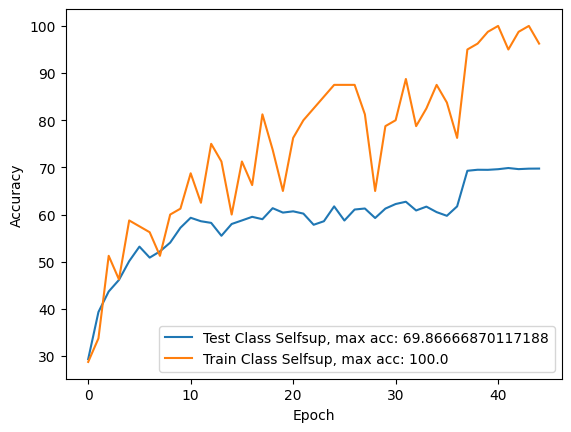

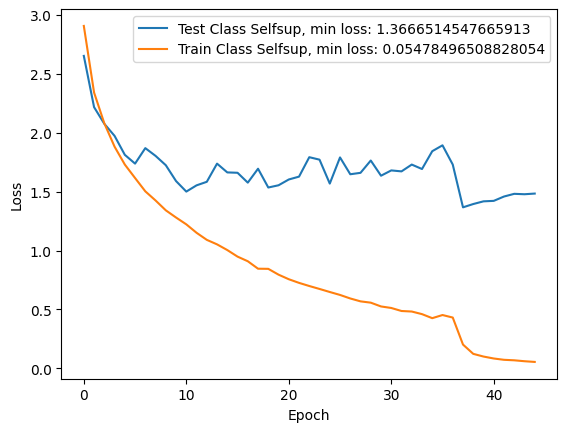

In [27]:
##Accuracy
acc_train_class_from_selfsup = np.asarray(acc_train_per_epoch)
acc_test_class_from_selfsup = np.asarray(acc_test_per_epoch)

#Loss per epoch
loss_train_class_from_selfsup = np.asarray(loss_train_epoch)
loss_test_class_from_selfsup  = np.asarray(loss_test_epoch)

numEpochs = len(acc_train_class_from_selfsup)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test_class_from_selfsup, label='Test Class Selfsup, max acc: ' + str(np.max(acc_test_class_from_selfsup)))
plt.plot(epochs, acc_train_class_from_selfsup, label='Train Class Selfsup, max acc: ' + str(np.max(acc_train_class_from_selfsup)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test_class_from_selfsup, label='Test Class Selfsup, min loss: ' + str(np.min(loss_test_class_from_selfsup)))
plt.plot(epochs, loss_train_class_from_selfsup, label='Train Class Selfsup, min loss: ' + str(np.min(loss_train_class_from_selfsup)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

# Classification task: training from scratch
Now we will train from scratch a model with the same architecture for the classification task.

This model will be used as a reference to measure the benefits provided by the self-supervised task.


## Create the dataloaders for the training and the validation (test) stages

In [28]:
# Nothing to do, same as before [Classification task: transfer learning from pretext task]

## Define the model architecture

In [29]:
# To fill: Create a new empty model with the same architecure as model_class
num_classes = num_classes_class = max(train_labels_class) - min(train_labels_class) + 1 ##num clases for classification
model_class_scratch = ResNet(BasicBlock, [3,4,6,3], int(num_classes)).to(device) ##ResNet-14
print(model_class_scratch) # Maybe you want to visualize it.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## Define the optimizer and the scheduler

In [30]:
# To fill: use the same paramters as for the previous learning in [Classification task: transfer learning from pretext task]
## Change associated hyperparamters to accelerate or improve training.
optimizer_tl_scratch = optim.SGD(model_class_scratch.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler_tl_scratch = optim.lr_scheduler.MultiStepLR(optimizer_tl_scratch, milestones=args.M_class, gamma=0.1)

## Training loop for classification task (scratch)

In [31]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch_class + 1):
    st = time.time()

    # To fill: Train for one epoch
    print("Classification Learning (RotNet) from scratch, epoch " + str(epoch))
    loss_per_epoch, top1_train_ac = train_RotNet_classification(args, model_class_scratch, device, train_loader_class, optimizer_tl_scratch, epoch)

    loss_train_epoch += [loss_per_epoch]

    scheduler_tl_scratch.step()

    # To fill: test/validate
    loss_per_epoch_test, acc_val_per_epoch_i = testing_classification(args, model_class_scratch, device, test_loader_class)

    loss_test_epoch += loss_per_epoch_test
    acc_train_per_epoch += [top1_train_ac.item()]
    acc_test_per_epoch += acc_val_per_epoch_i


    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i[-1]

    else:
        if acc_val_per_epoch_i[-1] > best_acc_val:
            best_acc_val = acc_val_per_epoch_i[-1]

    if epoch==args.epoch_class:
        torch.save(model_class_scratch.state_dict(), "RotNetClassFromScratch.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train_class_sct.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val_class_sct.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_train_class_sct.npy', np.asarray(acc_train_per_epoch))
    np.save(res_path + '/' + 'accuracy_per_epoch_val_class_sct.npy', np.asarray(acc_test_per_epoch))

    cont += 1

Classification Learning (RotNet) from scratch, epoch 1
Train Epoch: 1 [300/24000 (5%)]	Loss: 4.655079, Accuracy: 5%, Learning rate: 0.100000
Train Epoch: 1 [600/24000 (10%)]	Loss: 4.837237, Accuracy: 6%, Learning rate: 0.100000
Train Epoch: 1 [900/24000 (15%)]	Loss: 4.009756, Accuracy: 2%, Learning rate: 0.100000
Train Epoch: 1 [1200/24000 (20%)]	Loss: 3.821854, Accuracy: 2%, Learning rate: 0.100000
Train Epoch: 1 [1500/24000 (25%)]	Loss: 3.810359, Accuracy: 4%, Learning rate: 0.100000
Train Epoch: 1 [1800/24000 (30%)]	Loss: 3.609123, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [2100/24000 (35%)]	Loss: 3.759667, Accuracy: 5%, Learning rate: 0.100000
Train Epoch: 1 [2400/24000 (40%)]	Loss: 3.686301, Accuracy: 9%, Learning rate: 0.100000
Train Epoch: 1 [2700/24000 (45%)]	Loss: 3.731916, Accuracy: 1%, Learning rate: 0.100000
Train Epoch: 1 [3000/24000 (50%)]	Loss: 3.782047, Accuracy: 4%, Learning rate: 0.100000
Train Epoch: 1 [3300/24000 (55%)]	Loss: 3.800781, Accuracy: 6%, Lear

## Accuracy and loss curves for classification task (comparative)

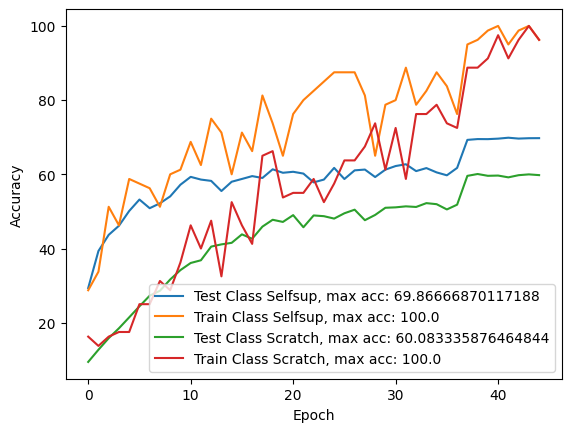

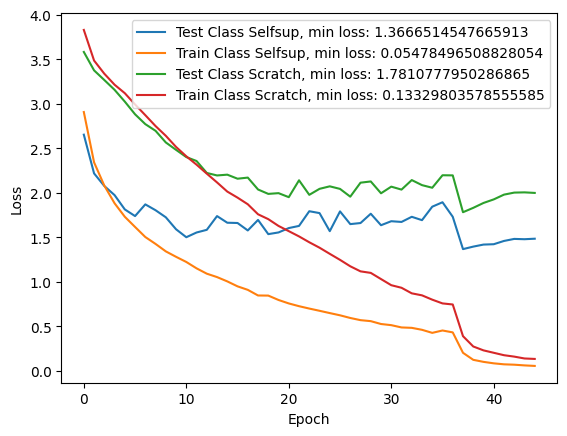

In [32]:
##Accuracy
acc_train_class_from_scratch = np.asarray(acc_train_per_epoch)
acc_test_class_from_scratch = np.asarray(acc_test_per_epoch)

#Loss per epoch
loss_train_class_from_scratch = np.asarray(loss_train_epoch)
loss_test_class_from_scratch  = np.asarray(loss_test_epoch)

numEpochs = len(acc_train_class_from_scratch)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test_class_from_selfsup, label='Test Class Selfsup, max acc: ' + str(np.max(acc_test_class_from_selfsup)))
plt.plot(epochs, acc_train_class_from_selfsup, label='Train Class Selfsup, max acc: ' + str(np.max(acc_train_class_from_selfsup)))
plt.plot(epochs, acc_test_class_from_scratch, label='Test Class Scratch, max acc: ' + str(np.max(acc_test_class_from_scratch)))
plt.plot(epochs, acc_train_class_from_scratch, label='Train Class Scratch, max acc: ' + str(np.max(acc_train_class_from_scratch)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test_class_from_selfsup, label='Test Class Selfsup, min loss: ' + str(np.min(loss_test_class_from_selfsup)))
plt.plot(epochs, loss_train_class_from_selfsup, label='Train Class Selfsup, min loss: ' + str(np.min(loss_train_class_from_selfsup)))
plt.plot(epochs, loss_test_class_from_scratch, label='Test Class Scratch, min loss: ' + str(np.min(loss_test_class_from_scratch)))
plt.plot(epochs, loss_train_class_from_scratch, label='Train Class Scratch, min loss: ' + str(np.min(loss_train_class_from_scratch)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


# Evaluate the natural clustering ability of the learned features

## T-SNE representations: final layer

Let's move on to plotting the models' representations in lower dimensions so we can visualize them.

We will use the t-Distributed Stochastic Neighbor Embedding (t-SNE) technique  to do this. It is a very useful dimensionality reduction technique for the visualization of high-dimensional datasets (as it happens with the representations of a CNN). You can find more information about t-SNE here: (https://lvdmaaten.github.io/tsne/)

First, we'll get the representations (features) from the models.
We will plot the t-SNE representations of just the outputs of the network



In [33]:
# To fill: complete the method based on prevous Lab. Assignment.
# Attention: Beware the differences in the batch iterator!
def get_representations(args, model, device, test_loader):

    model.eval()

    outputs = []
    labels = []

    with torch.no_grad():

        for batch_idx, (_,_,data,target,_) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            size = data.size()
            # forward pass
            y_pred = model(data)

            outputs.append(y_pred.cpu())
            labels.append(target.cpu())
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [34]:
# To fill: Get representations for each trained model, use the same dataset for the three of them, e.g. the test_loader_class
outputs_pretext, labels_pretext = get_representations(args, model_pretext, device, test_loader_class)
outputs_class, labels_class = get_representations(args, model_class, device, test_loader_class)
outputs_class_scratch, labels_class_scratch = get_representations(args, model_class_scratch, device, test_loader_class)

Now, let's define the functions to get the t-SNE representations in two dimensions and plot them.

In [35]:
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [36]:
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

Let's plot the t-SNE representations for a set of validation images.

Text(0.5, 1.0, 'Scratch')

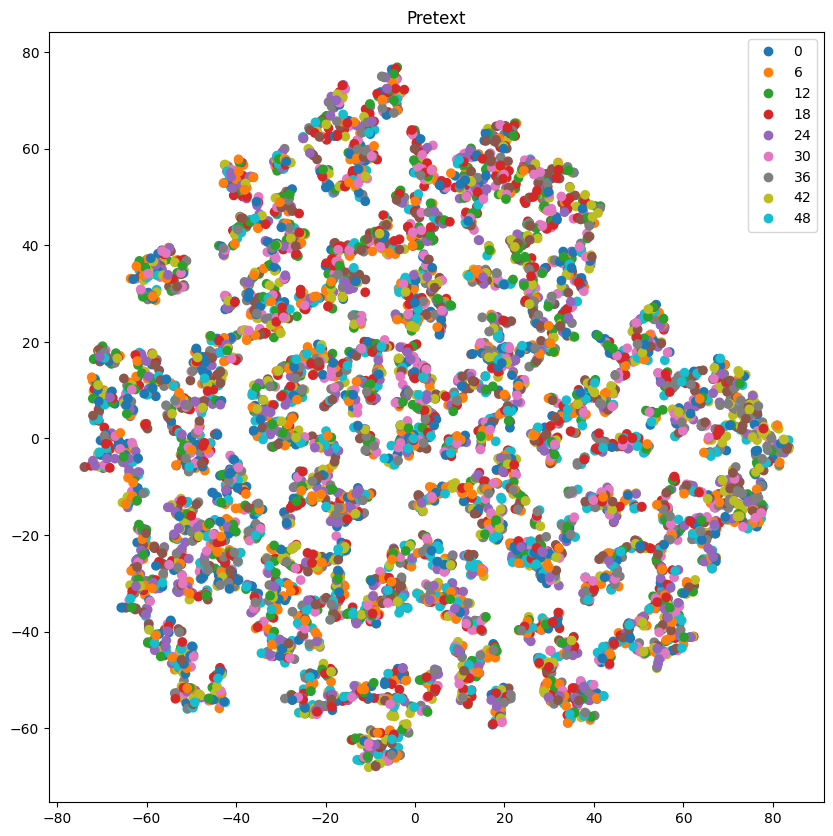

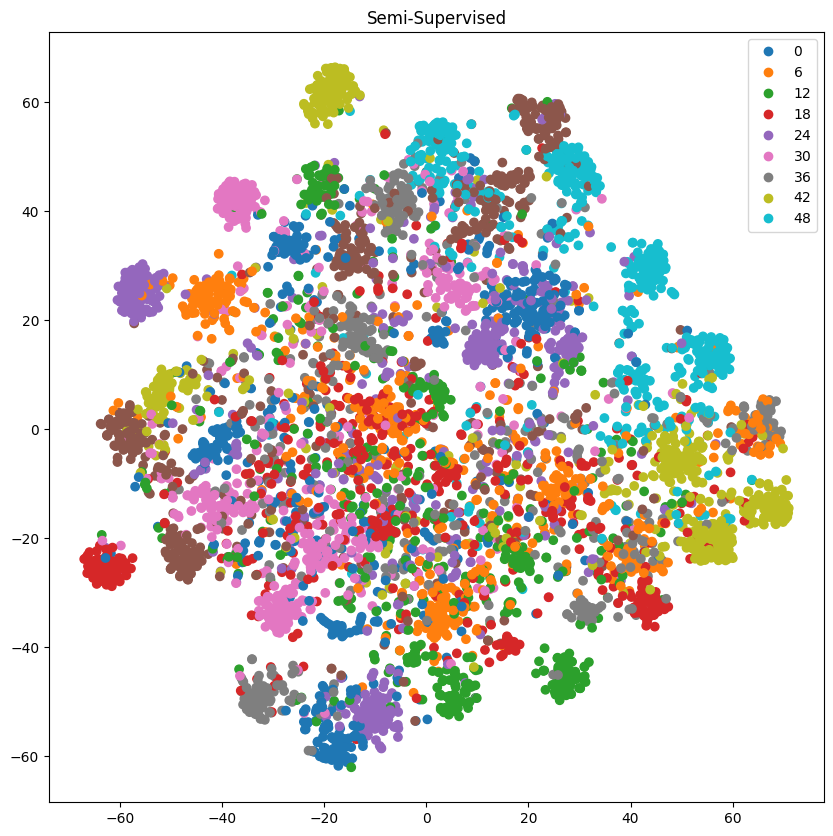

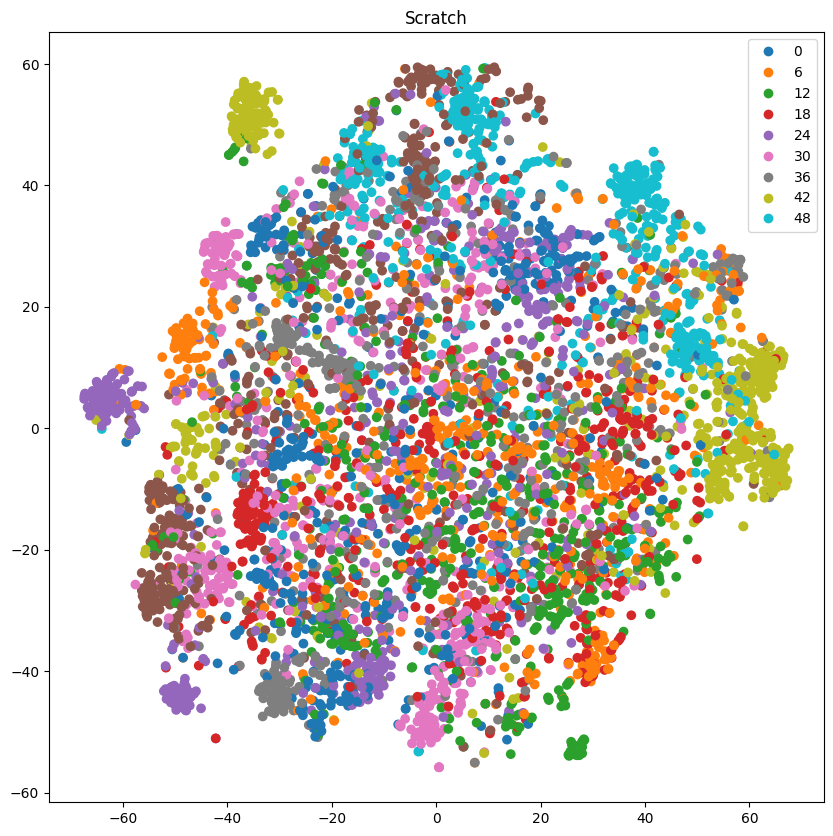

In [37]:
N_IMAGES = args.MaximumNumberOfImagesPerSet

output_tsne_data_pretext = get_tsne(outputs_pretext, n_images = N_IMAGES)
plot_representations(output_tsne_data_pretext, labels_pretext, n_images = N_IMAGES)
plt.title('Pretext')

output_tsne_data_class = get_tsne(outputs_class, n_images = N_IMAGES)
plot_representations(output_tsne_data_class, labels_class, n_images = N_IMAGES)
plt.title('Semi-Supervised')

output_tsne_data_scratch = get_tsne(outputs_class_scratch, n_images = N_IMAGES)
plot_representations(output_tsne_data_scratch, labels_class_scratch, n_images = N_IMAGES)
plt.title('Scratch')